## Лузина Владимира РИС22-2
# Семинар 11. Оценка качества классификации

Используя имеющиеся статистические данные выполнить следующие шаги:
1) классифцировать имеющиеся данные тремя способами: knn по 1 точке, по 3 точкам и деревом решений с глубиной 3
2) оценить качество классификации модели по характеристикам
3) Построить ROC кривые и сделать выводы о качестве работы методов

Я не стал удалять выбросы, так как это не связано с текущей задачей

In [78]:
import numpy as np
import pandas as pd
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)


In [79]:
np.random.seed(70) # сид, чтобы значения были одинаковые

df = pd.DataFrame({'day': [i for i in range(1, 21)],  # дни с 1 по 20
                   'price': np.random.uniform(4, 5, 20).round(2),  # стоимость
                   'amount': np.random.randint(10, 100, 20)})  # число продаж
df

,day,price,amount
0,1,4.93,45
1,2,4.87,88
2,3,4.58,97
3,4,4.91,44
4,5,4.32,90
5,6,4.15,51
6,7,4.86,44
7,8,4.43,93
8,9,4.49,23
9,10,4.45,91


Для выявления в разнородных совокупностях однородные подмножества и в дальнейшем работать уже с ними
Признак - класс 1 присваиваем дню, для которого:
  - Цены относительно предыдущего дня уменьшились или не изменились
  - И объём продаж увеличились или не изменился
В противном случае присваиваем класс 0

In [80]:
df["class"] = [0] + [1 if df["price"][i] <= df["price"][i - 1] and df["amount"][i] >= df["amount"][i - 1] else 0 for
                     i in range(1, 20)]
df

,day,price,amount,class
0,1,4.93,45,0
1,2,4.87,88,1
2,3,4.58,97,1
3,4,4.91,44,0
4,5,4.32,90,1
5,6,4.15,51,0
6,7,4.86,44,0
7,8,4.43,93,1
8,9,4.49,23,0
9,10,4.45,91,1


тестовая выборка эти дни кратные 3. Остальные данные это обучающая выборка
разделим на обучающую и тестовую выборки.

In [81]:
train = df[~(df["day"] % 3 == 0)]
test = df[df["day"] % 3 == 0]
X_train, X_test, y_train, y_test = train[["price", "amount"]], test[["price", "amount"]], train[["class"]], test[
    ["class"]]
print("test:")
display(X_test)
display(y_test)

test:


,price,amount
2,4.58,97
5,4.15,51
8,4.49,23
11,4.26,90
14,4.04,46
17,4.19,84


,class
2,1
5,0
8,0
11,1
14,0
17,1


Для первых двух классфикаций буду использовать knn для 1 и 3 соседей

In [82]:
from sklearn.neighbors import KNeighborsClassifier

# для 3
classifier_3 = KNeighborsClassifier(n_neighbors=1)
classifier_3.fit(X_train, y_train.values.ravel())
predict_knn_3 = classifier_3.predict(X_test)
# для 5
classifier_5 = KNeighborsClassifier(n_neighbors=3)
classifier_5.fit(X_train, y_train.values.ravel())
predict_knn_5 = classifier_5.predict(X_test)

Воспользуюсь DecisionTreeClassifier из библиотеки sklearn
Буду использовать Энтропия, а не Коэффициент Джини, так как он более чувствителен к неоднородности данных, хоть и более ресурсозатратный.
Также за максимальную глубину возьму 3, чтобы дерево не переобучилось на таком маленьком количестве данных и всего с двумя параметрами.
Конечно, этот параметр стоило бы подобрать на валидационной выборке, но данных неприлично мало

In [83]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(criterion="entropy", max_depth=3)  # объект классификатора
clf = clf.fit(X_train, y_train)  # обучаю классификатор на трейне
pred_tree = clf.predict(X_test)  # делаю предикт на тесте

Добавляю все предсказания в один датаафрейм

In [84]:
predicts = pd.DataFrame({"y": y_test["class"],"knn1": predict_knn_3, "knn3": predict_knn_5, "tree": pred_tree})
predicts

,y,knn1,knn3,tree
2,1,0,1,1
5,0,0,0,0
8,0,0,0,0
11,1,1,1,1
14,0,0,0,0
17,1,1,1,1


### Оцениваю качество классификация

In [85]:
TP = [sum(predicts["y"] * predicts["knn1"]), sum(predicts["y"] * predicts["knn3"]), sum(predicts["y"] * predicts["tree"])]
TN = [((predicts["y"] == 0) & (predicts["y"] == predicts["knn1"])).sum(),((predicts["y"] == 0) & (predicts["y"] == predicts["knn3"])).sum(),((predicts["y"] == 0) & (predicts["y"] == predicts["tree"])).sum()] 
FP = [predicts["y"].sum() - TP[0],predicts["y"].sum() - TP[1],predicts["y"].sum() - TP[2]]
FN = [(predicts["y"].count() - predicts["y"].sum()) - TN[0],(predicts["y"].count() - predicts["y"].sum()) - TN[1], (predicts["y"].count() - predicts["y"].sum()) - TN[2]]

accuracy = [(TP[i] + TN[i]) / (TP[i] + TN[i] + FP[i] + FN[i]) for i in range(3)]
precision = [TP[i] / (TP[i] + FP[i]) for i in range(3)]
rec = [TP[i] / (TP[i] + FN[i]) for i in range(3)]
s = [TN[i] / (TN[i] + FP[i]) for i in range(3)]

F_2 = [((1 + 2**2) * (precision[i] * rec[i]) / (2**2*precision[i] + rec[i])) if precision[i] + rec[i] != 0 else 0 for i in range(3)]
F_05 = [((1 + 0.5**2)*(precision[i] * rec[i]) / (0.5**2*precision[i] + rec[i])) if precision[i] + rec[i] != 0 else 0 for i in range(3)]

TPR  = rec
FPR = np.array([1,1,1]) - np.array(s)

metrics = pd.DataFrame({"TP": TP, "TN": TN, "FP":FP, "FN": FN, "acc": accuracy, "pre": precision, "rec": rec, "s": s, "F(B=2)": F_2, "F(B=0.5)": F_05, "TPR": TPR, "FPR": FPR})
metrics.T

,0,1,2
TP,2.000000,3.0,3.0
TN,3.000000,3.0,3.0
FP,1.000000,0.0,0.0
FN,0.000000,0.0,0.0
acc,0.833333,1.0,1.0
pre,0.666667,1.0,1.0
rec,1.000000,1.0,1.0
s,0.750000,1.0,1.0
F(B=2),0.909091,1.0,1.0
F(B=0.5),0.714286,1.0,1.0


Интерпретация всех метрик:
TP, TN - количество правильно предсказанных 1 и 0
FP, FN -  количество НЕправильно предсказанных 1 и 0
Acc - аккуратность - доля правильных ответов среди всех предсказаний
pre - точность - доля правильных ответов среди истинных предсказаний
Rec - полнота - Доля объектов, относящихся к истинным, классифицированная правильно
s - специфичность - Доля объектов, относящихся к ложным, классифицированная правильно
F(B) - среднее между точностью и плотностью. 
B от 0 до 1 если приоритет у точности, B > 1 приоритет отдаётся плотности
TPR - полнота
FPR - доля объектов, относящихся к истинным, классифицированная правильно

### Кривая рабочих характеристик (ROC)
Сравнивает долю ложно положительных примеров (FPR)
в сравнении с долей истинно положительных примеров (TPR)

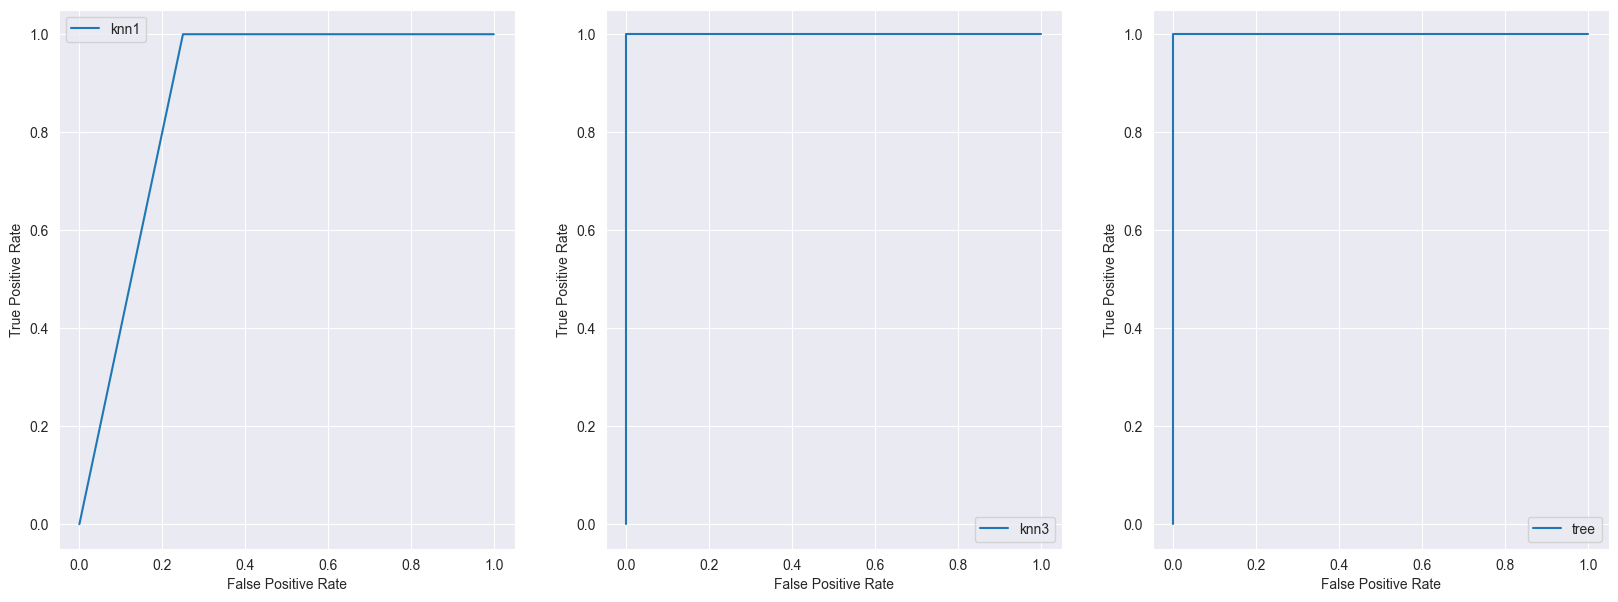

In [86]:
import matplotlib.pyplot as plt

_,ax = plt.subplots(1,3,figsize = (20,7))
names = predicts.items()
next(names)
for i in range(3):
   fpr_array = np.concatenate([[0], [metrics.iloc[i]["FPR"]], [1]])
   tpr_array = np.concatenate([[0], [metrics.iloc[i]["TPR"]], [1]])

   ax[i].plot(fpr_array, tpr_array, label=next(names,None)[0])
   ax[i].legend()
   ax[i].set_xlabel('False Positive Rate')
   ax[i].set_ylabel('True Positive Rate')
plt.show()

Если график вида y = x, значит доля правильных предсказаний равна доле неправильный и классификатор не имеет смысла (то есть, как в анекдоте, шанс верной классификации 50 на 50)

В моём же случаи все графики показывают отличную предсказательную способность. А в последних двух графиках она, можно сказать, вообще идеальная.

Для сравнения ROC обычно используют AOC (площадь под графиком). На глаз видно, что AOC у второго и третьего графика лучше (идеальная), следовательно, один из них и стоит выбрать в качестве модели, если бы данные имели смысл.